In [1]:
#basic librarires 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

#preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn import linear_model
#machine learning models
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#ensemble
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
#feature selection
from sklearn.feature_selection import RFE

#metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report,roc_curve,auc,confusion_matrix
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.impute import SimpleImputer
#pca
from sklearn.decomposition import PCA
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
#warnings
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

C:\Users\VISHY\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\VISHY\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\VISHY\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\VISHY\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

In [2]:
df=pd.read_csv('Train.csv',parse_dates=['DATE'])
df=df.drop('INCIDENT_ID',axis=1)
df.head()

,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,2004-07-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
1,2017-07-18,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
2,2017-03-15,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1
3,2009-02-13,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1
4,2005-04-13,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1


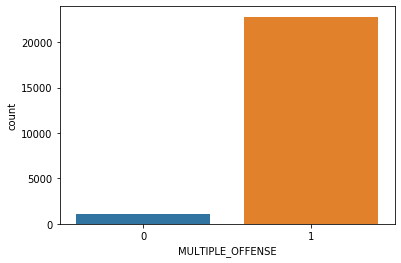

In [3]:
sns.countplot(df['MULTIPLE_OFFENSE'])

There's a huge class imbalance observed here. We'll try upsampling or Synthetic sampling techniques(SMOTE).

For dates, we'll extract day, year and week to see if there's any effect of either of them on the target variable.

In [4]:
df['Day']=df['DATE'].dt.day_name()
df['Year']=df['DATE'].dt.year
df['Week']=df['DATE'].dt.week

le=LabelEncoder()
df['Day']=le.fit_transform(df['Day'])
df=df.drop(['DATE'],axis=1)

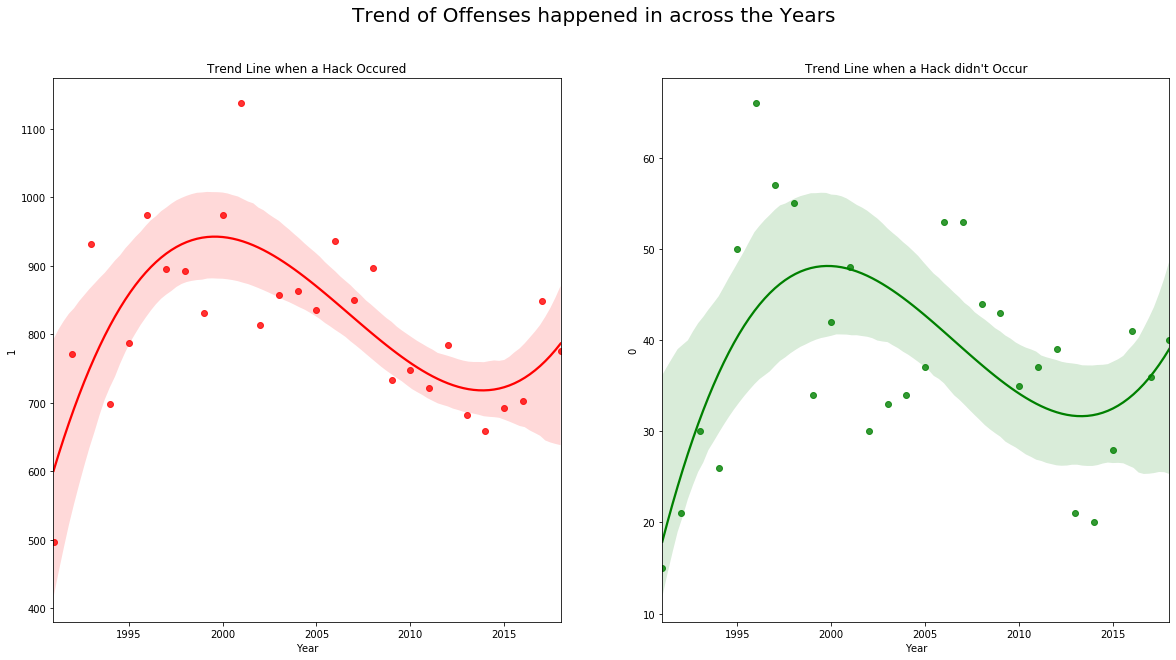

In [6]:
ss=pd.crosstab(df['MULTIPLE_OFFENSE'],df['Year'])
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
sns.regplot(ss.columns,ss.iloc[1:,:], order=3, ax=axes[0], color='r')
axes[0].set(title='Trend Line when a Hack Occured')
sns.regplot(ss.columns,ss.iloc[0:1,:], order=3, ax=axes[1], color='g')
axes[1].set(title="Trend Line when a Hack didn't Occur")

plt.suptitle('Trend of Offenses happened in across the Years', fontsize=20)
plt.show()

We can see downward trend in number of cases observed, the maximum cases occuring in 2000. The trend is largely on a downturn, but is picking up in 2013. The cases where hack didn;t happen also shows upturn largely due to the sheer volume of cases.

### Statistic tests for categorical variables

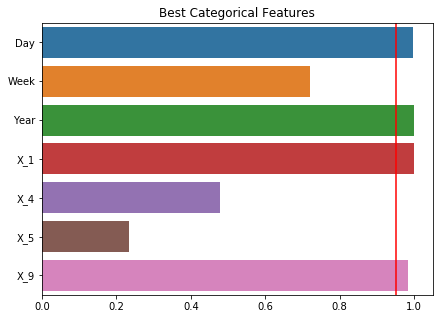

In [7]:
from scipy.stats import chi2_contingency
l=[]
categorical=['Day','Week','Year','X_1','X_4','X_5','X_9']
for i in categorical:
    pvalue  = chi2_contingency(pd.crosstab(df['MULTIPLE_OFFENSE'],df[i]))[1]
    l.append(1-pvalue)
plt.figure(figsize=(7,5))
sns.barplot(x=l, y=categorical)
plt.title('Best Categorical Features')
plt.axvline(x=(1-0.05),color='r')
plt.show()

Note: The above graph shows probability for accepting Alternative Hypothesis for visualisation representation purpose.

In [9]:
print('Nan values in the columns')
df.isna().sum()

Nan values in the columns


X_1                   0
X_2                   0
X_3                   0
X_4                   0
X_5                   0
X_6                   0
X_7                   0
X_8                   0
X_9                   0
X_10                  0
X_11                  0
X_12                182
X_13                  0
X_14                  0
X_15                  0
MULTIPLE_OFFENSE      0
Day                   0
Year                  0
Week                  0
dtype: int64

We observe nan values in the 'X_12' column. Let's observe the distribution of the column.

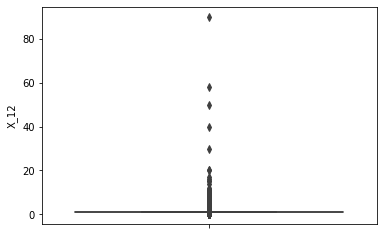

In [10]:
sns.boxplot(df['X_12'], orient='v')

Its a highly skewed distribution, so we'll need a complex imputation strategy for the nan values.

Out of the options of Simple Imputer, KNN Imputer, MICE or Iterative Imputer, we'll implement KNN Imputation for this purpose.

In [11]:
cols=df.columns
imp=KNNImputer(n_neighbors=5, missing_values=np.nan)
df=pd.DataFrame(imp.fit_transform(df.values),columns=cols)

### Statistical test for Numerical columns

Since there are two target samples, we'll use T Test.

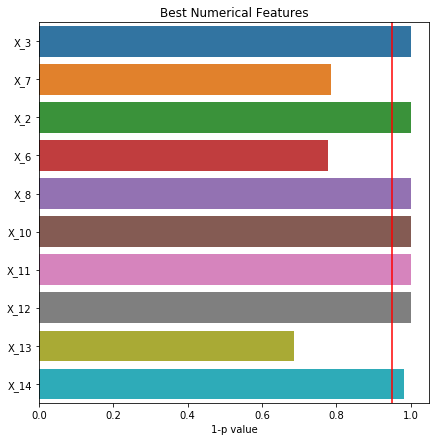

In [12]:
from scipy.stats import ttest_ind
num=['X_3', 'X_7', 'X_2', 'X_6', 'X_8', 'X_10', 'X_11', 'X_12', 'X_13', 'X_14']
p=[]

for i in num:
    df1=df.groupby('MULTIPLE_OFFENSE').get_group(0)
    df2=df.groupby('MULTIPLE_OFFENSE').get_group(1)
    t,pvalue=ttest_ind(df1[i],df2[i])
    p.append(1-pvalue)
plt.figure(figsize=(7,7))
sns.barplot(x=p, y=num)
plt.title('Best Numerical Features')
plt.axvline(x=(1-0.05),color='r')
plt.xlabel('1-p value')
plt.show()

Note: The above graph shows probability for accepting Alternative Hypothesis for visualisation representation purpose.

We'll drop the below columns.

In [13]:
df=df.drop(['X_4','X_5','Week','X_13','X_7','X_6'],axis=1)

In [14]:
X=df.drop('MULTIPLE_OFFENSE',axis=1)
y=df['MULTIPLE_OFFENSE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
smt=SMOTE(random_state=10) #FOR CLASS IMBALANCE
X_train, y_train = smt.fit_sample(X_train, y_train)

## Hyperparameter Tuning of XGBoost

In [17]:
param_test1 = {
 'max_depth':range(7,17,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='f1',n_jobs=4,iid=False, cv=3)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 9, 'min_child_weight': 1}, 0.9991817376433353)

In [18]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.4}, 0.9992985871289937)

In [19]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=1, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train,y_train)
gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.75, 'subsample': 0.8}, 0.9992985871289937)

In [20]:
param_test7 = {
 'reg_lambda':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=1, gamma=0.4, subsample=0.8, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch7.fit(X_train,y_train)
gsearch7.best_params_, gsearch7.best_score_

({'reg_lambda': 0.01}, 0.9992986810178346)

Lets search around 0.01 Lambda value

In [23]:
param_test8 = {
 'reg_lambda':[i/1000.0 for i in range(9,20,1)]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=1, gamma=0.4, subsample=0.8, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch8.fit(X_train,y_train)
gsearch8.best_params_, gsearch8.best_score_

({'reg_lambda': 0.01}, 0.9992986810178346)

#### Putting all the best parameters from above exercise in our final classifier

In [24]:
xgb = XGBClassifier(
 learning_rate =0.01,
 n_estimators=800,
 max_depth=9,
 min_child_weight=1,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.75,
 reg_lambda=0.01,
 objective= 'binary:logistic',
 nthread=4)
xgb.fit(X_train,y_train)
ypred=xgb.predict(X_test)
recall_score(ypred,y_test)

0.9994708994708995

Small levels of overfit was solved by tuning the Lambda, which is the L2 regularisation parameter.

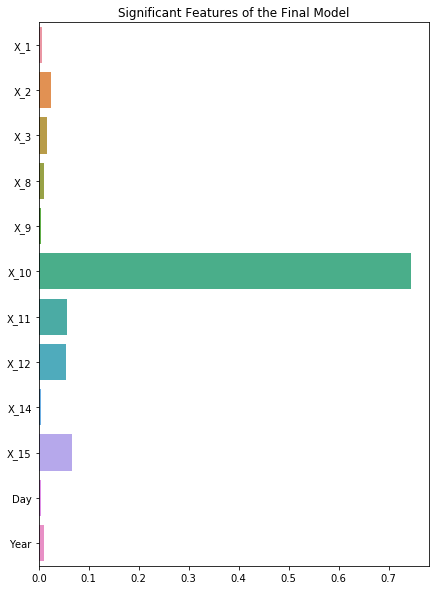

In [25]:
plt.figure(figsize=(7,10))
sns.barplot(x=xgb.feature_importances_,y=X.columns)
plt.title('Significant Features of the Final Model')
plt.show()

From above feature importance graph, the features X_1, X_9 and X_14 were removed due to lesser contribution to prediction, except Day which reduced the F1 score of the final model.

In [26]:
df=df.drop(['X_1','X_9','X_14'],axis=1)

In [29]:
X=df.drop('MULTIPLE_OFFENSE',axis=1)
y=df['MULTIPLE_OFFENSE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
smt=SMOTE(random_state=10) #FOR CLASS IMBALANCE
X_train, y_train = smt.fit_sample(X_train, y_train)

In [32]:
xgb = XGBClassifier(
 learning_rate =0.01,
 n_estimators=800,
 max_depth=9,
 min_child_weight=1,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.75,
 reg_lambda=0.01,
 objective= 'binary:logistic',
 nthread=4)
xgb.fit(X_train,y_train)
ypred=xgb.predict(X_test)
recall_score(ypred,y_test)

0.9994708994708995

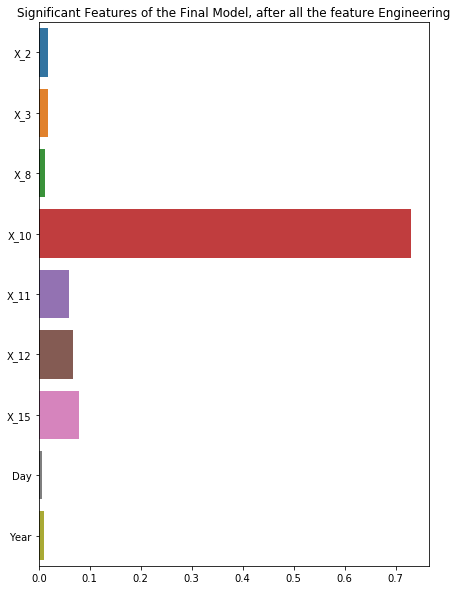

In [33]:
plt.figure(figsize=(7,10))
sns.barplot(x=xgb.feature_importances_,y=X.columns)
plt.title('Significant Features of the Final Model, after all the feature Engineering')
plt.show()

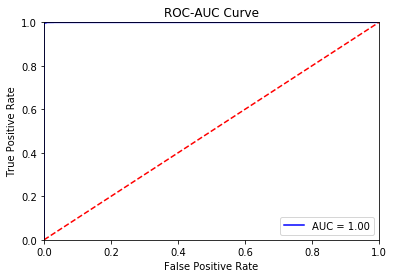

In [34]:
probs = xgb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC-AUC Curve')
plt.show()

The algorithm has great a AUC Score, and has an impressive ROC-AUC Curve.

In [35]:
confusion_matrix(y_test,ypred)

array([[ 291,    3],
       [   3, 5667]], dtype=int64)

## Conclusion

1. From statistical tests, the Day of the week has a significant impact in determing the target variable. The countplot doesn't show any trend (especially which on which day most offences occur), but certainly this variable is helpful, as also seen from the dramatic drop in performance upon its removal.
2. Among the Logging parameters, X_10 variable has significant importance in predicting the target variable, followed by X_15 and X_12.
3. X_1, X_9, X_14 didn't have significant contribution in the predictive power of the classifier.

## Test File

In [36]:
test=pd.read_csv('Test.csv', parse_dates=['DATE'])
test.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
0,CR_195453,2018-02-01,0,30,35,7,3,6,4,0,5,1,174,NaN,72,119,23
1,CR_103520,2004-03-05,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34
2,CR_196089,2018-01-27,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34
3,CR_112195,2006-08-18,7,3,2,3,5,9,8,0,5,1,174,1.0,112,87,34
4,CR_149832,2011-10-31,0,7,8,7,3,2,7,1,5,1,174,0.0,112,93,43


In [37]:
test['Day']=test['DATE'].dt.day_name()
test['Year']=test['DATE'].dt.year
test['Week']=test['DATE'].dt.week

In [38]:
le=LabelEncoder()
test['Day']=le.fit_transform(test['Day'])
ids=test['INCIDENT_ID']
test=test.drop(['INCIDENT_ID','DATE'],axis=1)

In [39]:
cols=test.columns
imp=KNNImputer(n_neighbors=5, missing_values=np.nan)
test=imp.fit_transform(test)
test=pd.DataFrame(test,columns=cols)

In [40]:
test=test.drop(['X_1','X_4','X_5','Week','X_13','X_7','X_6','X_9','X_14'],axis=1)

In [41]:
x=test.values

In [42]:
x = scaler.transform(x)

In [43]:
pred=xgb.predict(x)

In [44]:
submission = pd.DataFrame({'INCIDENT_ID': ids,
                           'MULTIPLE_OFFENSE':pred
                           })

submission.to_csv("final_sub.csv",index=False)